# Задание

Тебе предстоит изучить данные, содержащие значения измерений различных параметров скважины: дебиты, давления, температура и различные электротехнические параметры

и выполнить __следующие задачи:__

__Задача 0.__ Предложить варианты для заполнения пропущенных данных / предложить варианты по предварительной обработке данных

__Задача 1.__ Проверить эмпирическое правило: чем больше напряжение на ПЭД, тем больше дебит жидкости*

__Задача 2.__ Опираясь на имеющиеся данные, построить модель для предсказания дебита жидкости скважины

* в исходных данных параметр напряжение на ПЭД - столбец "U_AB", а дебит жидкости - "LIQ_RATE"


# Описание задачи

Объект исследования - нефтяная скважина, оборудованная погружным насосом  - УЭЦН (установка электроцентробежного насоса)

Всё оборудование скважины делится на два типа: наземное и подземное

На поверхности имеется возможность провести прямые измерения параметров: дебиты жидкости, давление, температура.

Частота измерений: __редко__ (раз в сутки)

Подземное оборудование представлено погружным насосом, снабженным датчиками телеметрии, которые позволяют измерять давление, температуру и электротехнические параметры насоса.

Частота измерений: __на постоянной основе__

Нефтяная скважина на поверхности выглядит следующим образом:

__Дебит жидкости скважины__ - важнейший технологический параметр скважины. Он определяет технологическую и экономическую эффективность работы скважины

Дебит жидкости - отношение количества продукции, протекающий через поперечное сечение трубопровода в единицу времени.

Может измеряться в м3/сут, тонн/сут и т.д.


__Проблема__: Измерение ключевого параметра скважины - дебита жидкости проводятся редко

__Гипотеза__: Имея данные замеров других параметров, можно спрогнозировать соответствующим им дебит жидкости

__Основная цель__: определелить значения дебита жидкости для скважины, используя данные замеров других параметров скважины

# Baseline solution


# Импорт библотек

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Загрузка исходных данных

In [2]:
df = pd.read_csv("/tf/datasets/test_well.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20020 entries, 0 to 20019
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DT_HOUR      20020 non-null  object 
 1   EXT_DATA     20020 non-null  int64  
 2   LIQ_RATE     146 non-null    float64
 3   OIL_RATE     146 non-null    float64
 4   WATER_CUT    146 non-null    float64
 5   PLIN         6602 non-null   float64
 6   QGAS         146 non-null    float64
 7   FREQ_HZ      6595 non-null   float64
 8   ACTIV_POWER  6592 non-null   float64
 9   PED_T        6595 non-null   float64
 10  PINP         6595 non-null   float64
 11  I_B          6596 non-null   float64
 12  I_A          6596 non-null   float64
 13  I_C          6595 non-null   float64
 14  U_AB         6595 non-null   float64
 15  U_BC         6595 non-null   float64
 16  U_CA         6595 non-null   float64
 17  U_OTP        0 non-null      float64
 18  COS_PHI      6595 non-null   float64
dtypes: f

### Переведем время в тип python из строки

In [3]:
df["DT_HOUR"] = pd.to_datetime(df['DT_HOUR'], format='%Y-%m-%dT')
df

,DT_HOUR,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
0,2021-03-21 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,0,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,0.0,37.17,29.5,29.4,29.6,396.0,399.0,399.0,NaN,71.0
3,2021-03-21 00:20:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,0,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20015,2021-06-20 23:39:18,0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,0.0,36.02,32.2,32.2,32.4,394.0,397.0,397.0,NaN,74.0
20016,2021-06-20 23:40:00,0,NaN,NaN,NaN,NaN,NaN,NaN,83.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20017,2021-06-20 23:59:47,0,NaN,NaN,NaN,18.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20018,2021-06-20 23:59:49,0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,0.0,36.03,32.2,32.3,32.3,394.0,399.0,397.0,NaN,74.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20020 entries, 0 to 20019
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DT_HOUR      20020 non-null  datetime64[ns]
 1   EXT_DATA     20020 non-null  int64         
 2   LIQ_RATE     146 non-null    float64       
 3   OIL_RATE     146 non-null    float64       
 4   WATER_CUT    146 non-null    float64       
 5   PLIN         6602 non-null   float64       
 6   QGAS         146 non-null    float64       
 7   FREQ_HZ      6595 non-null   float64       
 8   ACTIV_POWER  6592 non-null   float64       
 9   PED_T        6595 non-null   float64       
 10  PINP         6595 non-null   float64       
 11  I_B          6596 non-null   float64       
 12  I_A          6596 non-null   float64       
 13  I_C          6595 non-null   float64       
 14  U_AB         6595 non-null   float64       
 15  U_BC         6595 non-null   float64       
 16  U_CA

array([[<AxesSubplot: title={'center': 'EXT_DATA'}>,
        <AxesSubplot: title={'center': 'LIQ_RATE'}>,
        <AxesSubplot: title={'center': 'OIL_RATE'}>,
        <AxesSubplot: title={'center': 'WATER_CUT'}>],
       [<AxesSubplot: title={'center': 'PLIN'}>,
        <AxesSubplot: title={'center': 'QGAS'}>,
        <AxesSubplot: title={'center': 'FREQ_HZ'}>,
        <AxesSubplot: title={'center': 'ACTIV_POWER'}>],
       [<AxesSubplot: title={'center': 'PED_T'}>,
        <AxesSubplot: title={'center': 'PINP'}>,
        <AxesSubplot: title={'center': 'I_B'}>,
        <AxesSubplot: title={'center': 'I_A'}>],
       [<AxesSubplot: title={'center': 'I_C'}>,
        <AxesSubplot: title={'center': 'U_AB'}>,
        <AxesSubplot: title={'center': 'U_BC'}>,
        <AxesSubplot: title={'center': 'U_CA'}>],
       [<AxesSubplot: title={'center': 'U_OTP'}>,
        <AxesSubplot: title={'center': 'COS_PHI'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

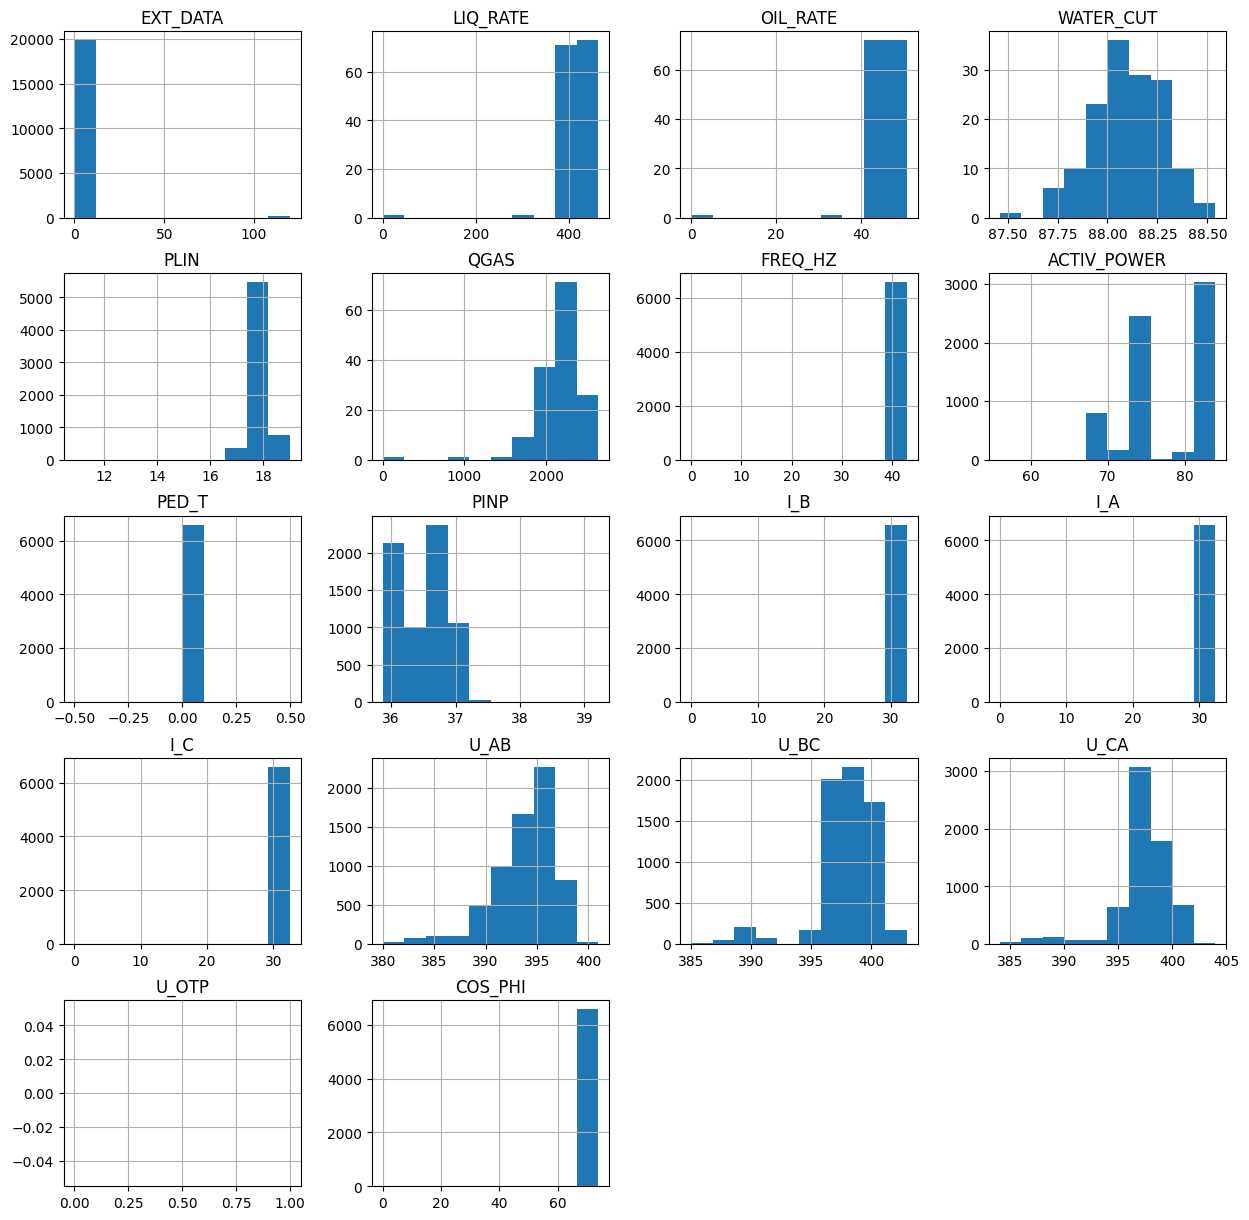

In [5]:
# Построим гистограммы распределения имеющихся данных
df.drop(labels='DT_HOUR', axis=1).hist(figsize=(15, 15))

In [6]:
# Рассчитаем коэффициенты корреляции для имеющихся пар признаков
df.corr()

,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
EXT_DATA,1.000000,0.377602,0.367712,-0.223022,NaN,0.654404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIQ_RATE,0.377602,1.000000,0.999124,-0.172351,NaN,0.736595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OIL_RATE,0.367712,0.999124,1.000000,-0.168536,NaN,0.738629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATER_CUT,-0.223022,-0.172351,-0.168536,1.000000,NaN,-0.157836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLIN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,-0.295260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QGAS,0.654404,0.736595,0.738629,-0.157836,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FREQ_HZ,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.999951,NaN,-0.768043,0.992460,0.992585,0.991434,-0.229342,-0.234222,-0.229051,NaN,0.936505
ACTIV_POWER,NaN,NaN,NaN,NaN,-0.29526,NaN,0.999951,1.000000,NaN,-0.982436,0.996465,0.986880,0.990603,-0.425663,-0.545837,NaN,NaN,0.734255
PED_T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PINP,NaN,NaN,NaN,NaN,NaN,NaN,-0.768043,-0.982436,NaN,1.000000,-0.828992,-0.827719,-0.833122,0.347631,0.353105,0.339842,NaN,-0.536600


<AxesSubplot: >

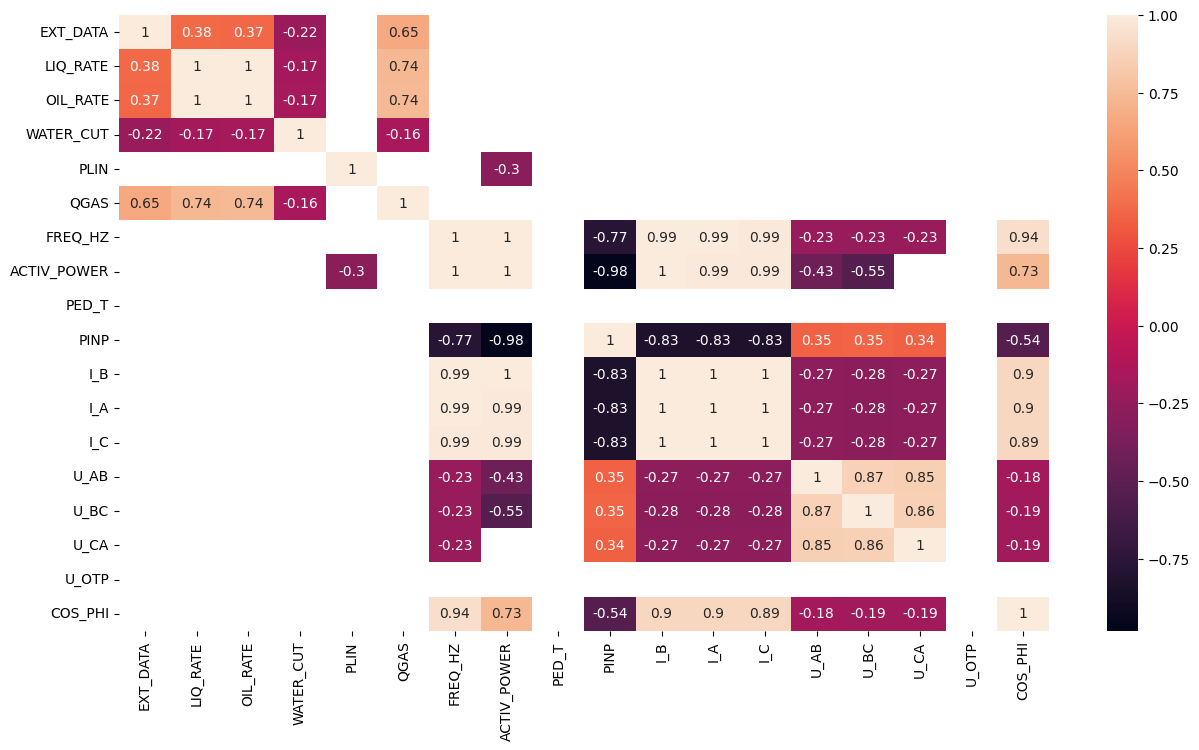

In [7]:
# Представим результат в графическом виде
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

# Предварительный анализ данных

Данные представляют из себя перечень замеров параметров одной скважины

По скважине в различные моменты времени представлены замеры дебитов жидкости, нефти, газа, обводненность, линейное давления,  электротехнические
параметры

Целевая переменная - __дебит жидкости__

Необходимо восстановить значения данного параметра, замеры которого находится в столбце с названием "__LIQ_RATE__"

In [8]:
df.describe()

,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
count,20020.000000,146.000000,146.000000,146.000000,6602.000000,146.000000,6595.000000,6592.000000,6595.0,6595.000000,6596.000000,6596.000000,6595.000000,6595.000000,6595.000000,6595.000000,0.0,6595.000000
mean,0.855245,415.724247,45.484384,88.097397,17.879284,2165.620274,41.782948,77.426187,0.0,36.535782,31.122165,31.111098,31.244458,394.055345,398.266262,397.039121,NaN,72.361183
std,10.060267,40.139969,4.454233,0.174743,0.350247,296.131190,1.701624,5.949151,0.0,0.377892,1.419314,1.416309,1.439096,2.871972,2.894213,2.860467,NaN,2.449727
min,0.000000,0.000000,0.000000,87.460000,10.890000,0.000000,0.000000,56.005000,0.0,35.870000,0.000000,0.000000,0.000000,380.000000,385.000000,384.000000,NaN,0.000000
25%,0.000000,403.240000,44.005000,87.980000,17.720000,2060.252500,41.000000,72.955000,0.0,36.170000,30.300000,30.300000,30.400000,392.000000,397.000000,396.000000,NaN,71.000000
50%,0.000000,413.825000,44.995000,88.100000,17.920000,2211.950000,41.000000,73.748000,0.0,36.680000,30.600000,30.600000,30.700000,394.000000,399.000000,397.000000,NaN,72.000000
75%,0.000000,436.287500,47.880000,88.220000,18.080000,2285.165000,43.000000,83.550000,0.0,36.810000,32.200000,32.200000,32.400000,396.000000,401.000000,399.000000,NaN,73.000000
max,120.000000,463.690000,50.900000,88.540000,19.010000,2642.390000,43.000000,83.900000,0.0,39.220000,32.400000,32.400000,32.500000,401.000000,403.000000,404.000000,NaN,74.000000


Заметно, что данные в столбце `EXT_DATA` могут пригодится, ведь ненулевые значения указывают на проведенные замеры редких характеристик

Для рассмотрения данных выделим отдельный датафрейм состоящий из целевых столбцов

In [9]:
target_df = df[df['EXT_DATA'] > 0].dropna(axis=1)
target_df = target_df.drop(labels=['EXT_DATA'], axis=1)

len(target_df.index)

146

In [10]:
target_df.describe()

,LIQ_RATE,OIL_RATE,WATER_CUT,QGAS
count,146.000000,146.000000,146.000000,146.000000
mean,415.724247,45.484384,88.097397,2165.620274
std,40.139969,4.454233,0.174743,296.131190
min,0.000000,0.000000,87.460000,0.000000
25%,403.240000,44.005000,87.980000,2060.252500
50%,413.825000,44.995000,88.100000,2211.950000
75%,436.287500,47.880000,88.220000,2285.165000
max,463.690000,50.900000,88.540000,2642.390000


In [11]:
param_df = df[df['EXT_DATA'] == 0].dropna(axis=1, how='all')
param_df = param_df.drop(labels=['PED_T', 'EXT_DATA'], axis=1)

len(param_df.index)

19874

In [12]:
param_df.describe()

,PLIN,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
count,6602.000000,6595.000000,6592.000000,6595.000000,6596.000000,6596.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000
mean,17.879284,41.782948,77.426187,36.535782,31.122165,31.111098,31.244458,394.055345,398.266262,397.039121,72.361183
std,0.350247,1.701624,5.949151,0.377892,1.419314,1.416309,1.439096,2.871972,2.894213,2.860467,2.449727
min,10.890000,0.000000,56.005000,35.870000,0.000000,0.000000,0.000000,380.000000,385.000000,384.000000,0.000000
25%,17.720000,41.000000,72.955000,36.170000,30.300000,30.300000,30.400000,392.000000,397.000000,396.000000,71.000000
50%,17.920000,41.000000,73.748000,36.680000,30.600000,30.600000,30.700000,394.000000,399.000000,397.000000,72.000000
75%,18.080000,43.000000,83.550000,36.810000,32.200000,32.200000,32.400000,396.000000,401.000000,399.000000,73.000000
max,19.010000,43.000000,83.900000,39.220000,32.400000,32.400000,32.500000,401.000000,403.000000,404.000000,74.000000


# Подготовка данных

In [13]:
df.sort_values(by='DT_HOUR', ascending=False, inplace=True)
df

,DT_HOUR,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
20019,2021-06-20 23:59:59,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20018,2021-06-20 23:59:49,0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,0.0,36.03,32.2,32.3,32.3,394.0,399.0,397.0,NaN,74.0
20017,2021-06-20 23:59:47,0,NaN,NaN,NaN,18.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20016,2021-06-20 23:40:00,0,NaN,NaN,NaN,NaN,NaN,NaN,83.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20015,2021-06-20 23:39:18,0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,0.0,36.02,32.2,32.2,32.4,394.0,397.0,397.0,NaN,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-03-21 00:38:32,0,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-03-21 00:20:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,0.0,37.17,29.5,29.4,29.6,396.0,399.0,399.0,NaN,71.0
1,2021-03-21 00:19:23,0,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
last_target_dt = None
for index, row in df.iterrows():
    if row['EXT_DATA'] > 0:
        last_target_dt = row['DT_HOUR']
    df.at[index, 'JOIN_DT'] = last_target_dt
df.dropna(subset='JOIN_DT', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19873 entries, 19872 to 0
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DT_HOUR      19873 non-null  datetime64[ns]
 1   EXT_DATA     19873 non-null  int64         
 2   LIQ_RATE     146 non-null    float64       
 3   OIL_RATE     146 non-null    float64       
 4   WATER_CUT    146 non-null    float64       
 5   PLIN         6553 non-null   float64       
 6   QGAS         146 non-null    float64       
 7   FREQ_HZ      6546 non-null   float64       
 8   ACTIV_POWER  6544 non-null   float64       
 9   PED_T        6546 non-null   float64       
 10  PINP         6546 non-null   float64       
 11  I_B          6547 non-null   float64       
 12  I_A          6547 non-null   float64       
 13  I_C          6546 non-null   float64       
 14  U_AB         6546 non-null   float64       
 15  U_BC         6546 non-null   float64       
 16  U_CA

In [15]:
df.drop(labels=['PED_T', 'EXT_DATA', 'U_OTP'], axis=1, inplace=True)
df.sort_values(by='DT_HOUR', ascending=True, inplace=True)
df

,DT_HOUR,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI,JOIN_DT
0,2021-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21 12:18:10
1,2021-03-21 00:19:23,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21 12:18:10
2,2021-03-21 00:19:26,NaN,NaN,NaN,NaN,NaN,40.0,NaN,37.17,29.5,29.4,29.6,396.0,399.0,399.0,71.0,2021-03-21 12:18:10
3,2021-03-21 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21 12:18:10
4,2021-03-21 00:38:32,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21 12:18:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19868,2021-06-20 07:20:00,NaN,NaN,NaN,NaN,NaN,NaN,83.642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-20 07:48:34
19869,2021-06-20 07:39:12,NaN,NaN,NaN,18.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-20 07:48:34
19870,2021-06-20 07:39:14,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.10,32.2,32.1,32.4,392.0,396.0,394.0,74.0,2021-06-20 07:48:34
19871,2021-06-20 07:40:00,NaN,NaN,NaN,NaN,NaN,NaN,83.638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-20 07:48:34


In [16]:
train_cols = ['PLIN', 'FREQ_HZ', 'ACTIV_POWER', 'PINP', 'I_A', 'I_B', 'I_C', 'U_AB', 'U_BC', 'U_CA', 'COS_PHI']
target_cols = ['LIQ_RATE', 'OIL_RATE', 'QGAS', 'WATER_CUT']

## Детекция и подавление выбросов

In [17]:
df[train_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19873 entries, 0 to 19872
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLIN         6553 non-null   float64
 1   FREQ_HZ      6546 non-null   float64
 2   ACTIV_POWER  6544 non-null   float64
 3   PINP         6546 non-null   float64
 4   I_A          6547 non-null   float64
 5   I_B          6547 non-null   float64
 6   I_C          6546 non-null   float64
 7   U_AB         6546 non-null   float64
 8   U_BC         6546 non-null   float64
 9   U_CA         6546 non-null   float64
 10  COS_PHI      6546 non-null   float64
dtypes: float64(11)
memory usage: 1.8 MB


In [18]:
def sigma_rule(with_outliers):
    clean = with_outliers.copy()
    for col in train_cols:
        std = df[col].std()
        mean = df[col].mean()
        for index, value in df[col].iteritems():
            if not value:
                continue
            if (mean - 3 * std) <= value <= (mean + 3 * std):
                continue
            df.at[index, col] = None
    return clean

In [19]:
df = sigma_rule(df)
df[train_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19873 entries, 0 to 19872
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLIN         6553 non-null   float64
 1   FREQ_HZ      6546 non-null   float64
 2   ACTIV_POWER  6544 non-null   float64
 3   PINP         6546 non-null   float64
 4   I_A          6547 non-null   float64
 5   I_B          6547 non-null   float64
 6   I_C          6546 non-null   float64
 7   U_AB         6546 non-null   float64
 8   U_BC         6546 non-null   float64
 9   U_CA         6546 non-null   float64
 10  COS_PHI      6546 non-null   float64
dtypes: float64(11)
memory usage: 2.3 MB


## Заполним отсутствующие значения

In [20]:
def impute_with_latest(to_impute):
    imputed = to_impute.copy()
    unique_cols = [*train_cols, 'JOIN_DT']
    last_values = imputed.iloc[0][train_cols]
    for index, row in imputed[train_cols].iterrows():
        to_replace = row.isna()
        for col in row[~to_replace].index:
            last_values[col] = row[col]
        for col in row[to_replace].index:
            imputed.at[index, col] = last_values[col]
    imputed.dropna(subset=train_cols, inplace=True)
    imputed.drop_duplicates(subset=unique_cols, keep='last', inplace=True)
    return imputed

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19873 entries, 0 to 19872
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DT_HOUR      19873 non-null  datetime64[ns]
 1   LIQ_RATE     146 non-null    float64       
 2   OIL_RATE     146 non-null    float64       
 3   WATER_CUT    146 non-null    float64       
 4   PLIN         6553 non-null   float64       
 5   QGAS         146 non-null    float64       
 6   FREQ_HZ      6546 non-null   float64       
 7   ACTIV_POWER  6544 non-null   float64       
 8   PINP         6546 non-null   float64       
 9   I_B          6547 non-null   float64       
 10  I_A          6547 non-null   float64       
 11  I_C          6546 non-null   float64       
 12  U_AB         6546 non-null   float64       
 13  U_BC         6546 non-null   float64       
 14  U_CA         6546 non-null   float64       
 15  COS_PHI      6546 non-null   float64       
 16  JOIN

In [22]:
df = impute_with_latest(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18985 entries, 2 to 19872
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DT_HOUR      18985 non-null  datetime64[ns]
 1   LIQ_RATE     146 non-null    float64       
 2   OIL_RATE     146 non-null    float64       
 3   WATER_CUT    146 non-null    float64       
 4   PLIN         18985 non-null  float64       
 5   QGAS         146 non-null    float64       
 6   FREQ_HZ      18985 non-null  float64       
 7   ACTIV_POWER  18985 non-null  float64       
 8   PINP         18985 non-null  float64       
 9   I_B          18985 non-null  float64       
 10  I_A          18985 non-null  float64       
 11  I_C          18985 non-null  float64       
 12  U_AB         18985 non-null  float64       
 13  U_BC         18985 non-null  float64       
 14  U_CA         18985 non-null  float64       
 15  COS_PHI      18985 non-null  float64       
 16  JOIN

In [23]:
# Группируем по дням показатели замеров и находим среднее значение для каждого дня
df = df.groupby("JOIN_DT").agg("mean")
df

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
JOIN_DT,,,,,,,,,,,,,,,
2021-03-21 12:18:10,388.84,42.61,87.46,17.825283,1853.77,40.0,67.926915,37.175943,29.434906,29.436792,29.534906,396.000000,399.000000,399.000000,71.000000
2021-03-22 02:03:33,390.57,42.59,88.04,17.720887,1809.27,40.0,68.148613,37.170323,29.478226,29.483871,29.568548,394.790323,398.774194,398.951613,71.000000
2021-03-23 16:37:56,395.10,42.47,87.95,17.723415,1822.53,40.0,68.067009,37.149421,29.454878,29.453049,29.552744,394.756098,399.942073,397.740854,71.000000
2021-03-24 19:17:29,389.34,42.54,88.02,17.781581,1855.33,40.0,68.095530,37.146795,29.452991,29.441026,29.534615,394.884615,399.897436,397.658120,71.000000
2021-03-25 10:03:37,391.28,42.55,88.22,17.848770,1827.74,40.0,68.085361,37.139918,29.450820,29.445082,29.519672,396.155738,400.950820,399.459016,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16 07:48:03,435.36,47.78,88.12,17.866316,2247.43,43.0,83.647211,36.045895,32.242105,32.195789,32.383158,394.547368,398.010526,397.105263,73.000000
2021-06-17 23:59:01,455.25,49.96,88.43,17.848808,1416.76,43.0,83.600224,36.033110,32.222965,32.197384,32.372674,393.250000,397.348837,395.706395,73.000000
2021-06-18 08:59:47,433.74,47.62,88.32,17.999753,2166.77,43.0,83.446370,36.048642,32.206173,32.211111,32.361728,392.320988,396.629630,395.209877,73.000000


In [24]:
df.corr()

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
LIQ_RATE,1.000000,0.999124,-0.172351,0.034507,0.736595,0.391720,0.368471,-0.362222,0.388311,0.386911,0.386812,-0.210280,-0.208166,-0.215461,0.395030
OIL_RATE,0.999124,1.000000,-0.168536,0.033296,0.738629,0.416380,0.394496,-0.387542,0.413344,0.411982,0.411896,-0.217104,-0.216629,-0.222836,0.415667
WATER_CUT,-0.172351,-0.168536,1.000000,0.008859,-0.157836,0.045878,0.078036,-0.077157,0.052759,0.053842,0.054090,-0.042155,-0.035681,-0.053715,0.047856
PLIN,0.034507,0.033296,0.008859,1.000000,0.037209,0.084880,0.058210,-0.077013,0.062172,0.060164,0.061497,0.280867,0.317993,0.310788,0.110706
QGAS,0.736595,0.738629,-0.157836,0.037209,1.000000,0.405946,0.387708,-0.350065,0.398699,0.398520,0.397547,-0.093005,-0.092704,-0.103947,0.375649
FREQ_HZ,0.391720,0.416380,0.045878,0.084880,0.405946,1.000000,0.981324,-0.973831,0.997886,0.997785,0.997721,-0.342814,-0.347122,-0.338923,0.899094
ACTIV_POWER,0.368471,0.394496,0.078036,0.058210,0.387708,0.981324,1.000000,-0.980510,0.988812,0.989027,0.989549,-0.355873,-0.362721,-0.354912,0.856456
PINP,-0.362222,-0.387542,-0.077157,-0.077013,-0.350065,-0.973831,-0.980510,1.000000,-0.978872,-0.978518,-0.979148,0.378775,0.381962,0.370456,-0.842707
I_B,0.388311,0.413344,0.052759,0.062172,0.398699,0.997886,0.988812,-0.978872,1.000000,0.999919,0.999902,-0.373017,-0.379243,-0.368509,0.892490
I_A,0.386911,0.411982,0.053842,0.060164,0.398520,0.997785,0.989027,-0.978518,0.999919,1.000000,0.999917,-0.373337,-0.379578,-0.368835,0.892588


<AxesSubplot: >

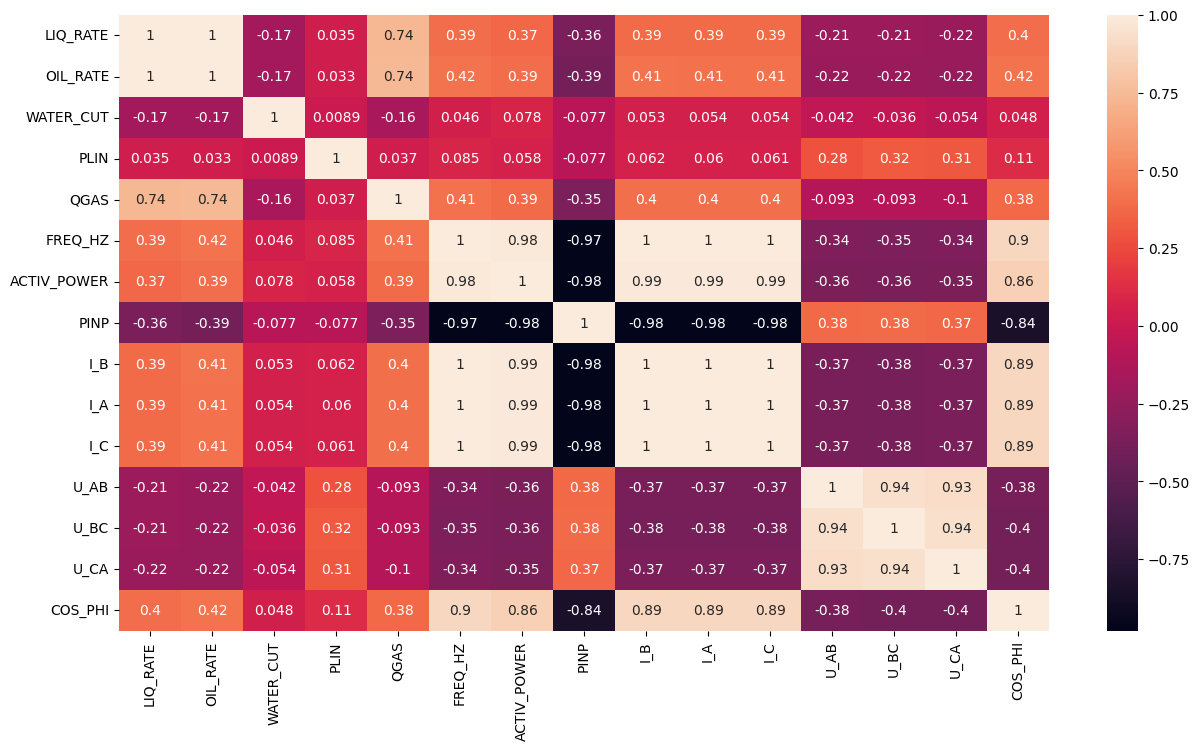

In [25]:
# Представим результат в графическом виде
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

# Результат по задаче 1

Корреляция между напряжением и дебитом жидкости отрицательная, что свидетельствует об обратной зависимости между этими величинами

Чем выше напряжение, тем __ниже__ дебит жидкости

Кроме того, корреляция __слаба__, что свидетельствует о __слабой зависимости__ этих двух величин в целом

# Построение модели линейной регрессии

In [26]:
# Отбираем фичи для построения модели
# model_cols = ['ACTIV_POWER']
# model_cols = train_cols
# model_cols = ['FREQ_HZ', 'COS_PHI', 'ACTIV_POWER']
model_cols = ['FREQ_HZ']
used_df = df[model_cols + target_cols]
used_df

,FREQ_HZ,LIQ_RATE,OIL_RATE,QGAS,WATER_CUT
JOIN_DT,,,,,
2021-03-21 12:18:10,40.0,388.84,42.61,1853.77,87.46
2021-03-22 02:03:33,40.0,390.57,42.59,1809.27,88.04
2021-03-23 16:37:56,40.0,395.10,42.47,1822.53,87.95
2021-03-24 19:17:29,40.0,389.34,42.54,1855.33,88.02
2021-03-25 10:03:37,40.0,391.28,42.55,1827.74,88.22
...,...,...,...,...,...
2021-06-16 07:48:03,43.0,435.36,47.78,2247.43,88.12
2021-06-17 23:59:01,43.0,455.25,49.96,1416.76,88.43
2021-06-18 08:59:47,43.0,433.74,47.62,2166.77,88.32


In [27]:
X = used_df[model_cols]
Y = used_df["LIQ_RATE"]

In [28]:
X

,FREQ_HZ
JOIN_DT,
2021-03-21 12:18:10,40.0
2021-03-22 02:03:33,40.0
2021-03-23 16:37:56,40.0
2021-03-24 19:17:29,40.0
2021-03-25 10:03:37,40.0
...,...
2021-06-16 07:48:03,43.0
2021-06-17 23:59:01,43.0
2021-06-18 08:59:47,43.0


In [29]:
Y

JOIN_DT
2021-03-21 12:18:10    388.84
2021-03-22 02:03:33    390.57
2021-03-23 16:37:56    395.10
2021-03-24 19:17:29    389.34
2021-03-25 10:03:37    391.28
                        ...  
2021-06-16 07:48:03    435.36
2021-06-17 23:59:01    455.25
2021-06-18 08:59:47    433.74
2021-06-19 21:13:52    433.52
2021-06-20 07:48:34    433.29
Name: LIQ_RATE, Length: 146, dtype: float64

# Разбиваем данные на тренировочную и тестовую выборки

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
len(X_train.index)

97

# Обучаем модель

In [31]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                  ('linear', LinearRegression())])
model.fit(X_train, Y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression())])

# Делаем прогноз

In [32]:
Y_predicted = model.predict(X_test)

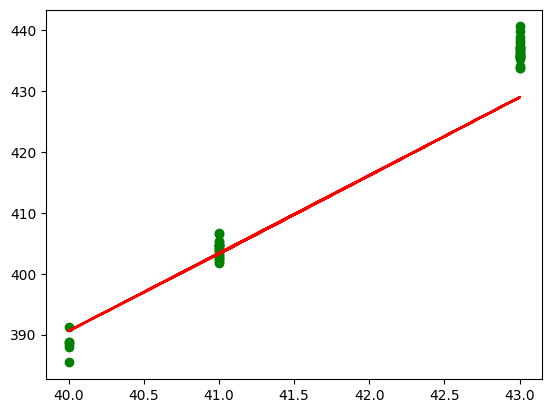

In [33]:
# Визуализация полученных результатов
plt.scatter(X_test, Y_test, color="green")
plt.plot(X_test, Y_predicted, color="red")

# Оценка качества модели

In [34]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predicted)))
print('R2 Score:', metrics.r2_score(Y_test, Y_predicted))

Mean Absolute Error: 4.3733981189409254
Mean Squared Error: 30.25199029912596
Root Mean Squared Error: 5.5001809333080995
R2 Score: 0.9138256994981946


# Результаты по задаче 2

Baseline solution `R2 Score`: __0.8867__
My solution `R2 Score`: __0.9138__